## Training a Masked Autoencoder

In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table
from time import time
import h5py

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

from gaiaxpy import generate, PhotometricSystem

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

Converting to GPU if available

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Checking directory

In [3]:
%%bash
cd /scratch/
pwd

/scratch


In [4]:
# scalers for dataloading
metscaler = StandardScaler(); logscaler = StandardScaler(); tefscaler = StandardScaler()
# extscaler = StandardScaler(); parscaler = StandardScaler()
scale = 'teff_xp_scale'

xp_nhead = 10
xp_num_layers = 4
mg_nhead = 2
mg_num_layers = 4
batchlen = 128
lr = 1e-4
num_epochs = 20
# datafname = "/arc/home/aydanmckay/mae_tab/scale_lamost_pristine_bprp_gmag.h5"
datafname = "/arc/home/aydanmckay/mae_tab/scale_lamost_apogee_pristine_bprp_gmag.h5"
datashort = 'T_MAE_v2_LAP'
# defining the reconstruction loss function
recon_xp_loss = nn.MSELoss()
recon_mg_loss = nn.MSELoss()
# defining the prediction loss function
pred_loss = nn.MSELoss()

In [5]:
def random_mask_tensor(tensor, num_mask):
    length = tensor.numel()
    mask = torch.zeros(length, dtype=torch.bool).to(device)
    mask[torch.randperm(length)[:num_mask]] = True
    return tensor.masked_fill(mask.reshape(tensor.shape), 0)

In [6]:
# defining the Dataset class
class data_set(Dataset):
    '''
    Main way to access the .h5 file.
    '''
    def __init__(self,file,train=True,valid=False,test=False,noscale=False):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        if train:
            name = 'group_1'
        elif valid:
            name = 'group_2'
        elif test or noscale:
            name = 'group_3'
        
        dset = self.f[name]['theta']
        dl = dset[:]
        # ----------------------------------------------------
        # if noscale:
        #     self.l = dl.shape[1]
        #     self.t = torch.Tensor(dl.T)
        # else:
        #     dat = np.array([
        #         metscaler.fit_transform(dl[[0]].T).flatten(),
        #         logscaler.fit_transform(dl[[1]].T).flatten(),
        #         tefscaler.fit_transform(dl[[2]].T).flatten(),
        #     ])
        #     self.l = dat.shape[1]
        #     self.t = torch.Tensor(dat.T)
        # ----------------------------------------------------
        if noscale:
            self.l = dl.shape[1]
            self.t = torch.Tensor(dl.T)
        else:
            dat = np.array([
                dl[[0]].flatten(),
                dl[[1]].flatten(),
                tefscaler.fit_transform(dl[[2]].T).flatten(),
            ])
            self.l = dat.shape[1]
            self.t = torch.Tensor(dat.T)
        # ----------------------------------------------------
        
        ydset = self.f[name]['bprp']
        ydat = ydset[:]
        self.y = torch.Tensor(ydat[:].T)

        errdset = self.f[name]['e_bprp']
        self.err = torch.Tensor(errdset[:].T)
        
        mdset = self.f[name]['mags']
        self.m = torch.Tensor(mdset[:].T)
        
        ddset = self.f[name]['dist']
        self.d = torch.Tensor(ddset[:].T)
        
        edset = self.f[name]['ext']
        self.e = torch.Tensor(edset[:].T)
        
    def __len__(self):
        return self.l
  
    def __getitem__(self, index):
        tg = self.t[index]
        yg = self.y[index]
        mg = self.m[index]
        errg = self.err[index]
        eg = self.e[index]
        dg = self.d[index]
        return (tg,yg,errg,mg,eg,dg)

In [7]:
class TMAE(nn.Module):
    def __init__(self, xp_nhead, xp_num_layers, mg_nhead, mg_num_layers, xp_mask = 55 * 128, mag_mask = 2 * 128):
        super(TMAE, self).__init__()
        
        self.xp_mask = xp_mask
        self.mag_mask = mag_mask
        
        self.xps_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=110, nhead=xp_nhead),
            num_layers=xp_num_layers
        )
        self.mag_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=4, nhead=mg_nhead),
            num_layers=mg_num_layers
        )
        
        self.xps_encoder = nn.Linear(110, 256)
        
        self.mag_encoder = nn.Linear(4, 16)
        
        self.decoder = nn.Sequential(
            nn.Linear(256 + 16, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 114)
        )
        
        self.mlp = nn.Sequential(
            nn.Linear(256 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
    
    def forward(self, xp, m):
        masked_xp = random_mask_tensor(xp, self.xp_mask)
        masked_ms = random_mask_tensor(m, self.mag_mask)
        encoded_xp = self.xps_transformer(masked_xp)
        encoded_ms = self.mag_transformer(masked_ms)
        encoded_xp = self.xps_encoder(masked_xp)
        encoded_ms = self.mag_encoder(masked_ms)
        z = torch.cat([encoded_xp, encoded_ms], dim=1)
        decoded = self.decoder(z)
        predicted = self.mlp(z)
        return (decoded[:, :110], decoded[:, 110:], predicted)

In [8]:
training_data = data_set(datafname)
valid_data = data_set(datafname,train=False,valid=True)

In [9]:
train_dataloader = DataLoader(
    training_data,
    batch_size=batchlen,
    shuffle=True,
    num_workers=0
)
valid_dataloader = DataLoader(
    valid_data,
    batch_size=batchlen,
    shuffle=True,
    num_workers=0
)

In [10]:
model = TMAE(xp_nhead, xp_num_layers, mg_nhead, mg_num_layers)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
normalize = lambda x, n: x / (10 ** (8.5 - n / 2.5))

def train(model, dataloader, recon_xp_loss, recon_mg_loss, pred_loss, optimizer):
    model.train()
    train_loss = 0.0
    run_mg_recon_loss = 0.0
    run_xp_recon_loss = 0.0
    running_pred_loss = 0.0
    for thetas, xps, xp_es, ms, exts, dists in dataloader:
        xps = xps.to(device)
        ms = ms.to(device)
        thetas = thetas.to(device)
        optimizer.zero_grad()
        
        dists = dists.to(device)
        xps = normalize(xps.T, dists).T

        # predicting
        output_xp, output_mag, preds = model(xps, ms)

        # computing the individual losses
        recon_xp_error = recon_xp_loss(output_xp, xps)
        recon_mg_error = recon_mg_loss(output_mag, ms)
        pred_error = pred_loss(preds, thetas)

        # computing the total loss
        loss = recon_xp_error + recon_mg_error + pred_error

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        # updating the running loss
        run_xp_recon_loss += recon_xp_error.item() * xps.size(0)
        run_mg_recon_loss += recon_mg_error.item() * ms.size(0)
        running_pred_loss += pred_error.item() * preds.size(0)
        train_loss += loss.item() * xps.size(0)

    # printing the two losses separately
    print("Epoch %d BP/RP Reconstruction Loss: %.3f m Reconstruction Loss: %.3f Prediction Loss: %.3f" % (epoch+1,
                                                                              run_xp_recon_loss/len(dataloader.dataset),
                                                                              run_mg_recon_loss/len(dataloader.dataset),
                                                                              running_pred_loss/len(dataloader.dataset),
                                                                              ))
    return train_loss / len(dataloader.dataset)

def validate(model, dataloader, recon_xp_loss, recon_mg_loss, pred_loss):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for thetas, xps, xp_es, ms, exts, dists in dataloader:
            xps = xps.to(device)
            ms = ms.to(device)
            thetas = thetas.to(device)
            
            dists = dists.to(device)
            xps = normalize(xps.T, dists).T

            # predicting
            output_xp, output_mag, preds = model(xps, ms)

            # computing the individual losses
            recon_xp_error = recon_xp_loss(output_xp, xps)
            recon_mg_error = recon_mg_loss(output_mag, ms)
            pred_error = pred_loss(preds, thetas)

            # computing the total loss
            loss = recon_xp_error + recon_mg_error + pred_error
            val_loss += loss.item() * xps.size(0)
    return val_loss / len(dataloader.dataset)

In [12]:
# training the algorithm
ntlosses = []
nvlosses = []
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, recon_xp_loss, recon_mg_loss, pred_loss, optimizer)
    val_loss = validate(model, valid_dataloader, recon_xp_loss, recon_mg_loss, pred_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    ntlosses.append(train_loss)
    nvlosses.append(val_loss)
    

Epoch 1 BP/RP Reconstruction Loss: 0.014 m Reconstruction Loss: 2.499 Prediction Loss: 0.395
Epoch 1/20: Train Loss=2.9084, Val Loss=0.5251
Epoch 2 BP/RP Reconstruction Loss: 0.004 m Reconstruction Loss: 0.160 Prediction Loss: 0.199
Epoch 2/20: Train Loss=0.3626, Val Loss=0.3266
Epoch 3 BP/RP Reconstruction Loss: 0.003 m Reconstruction Loss: 0.145 Prediction Loss: 0.171
Epoch 3/20: Train Loss=0.3196, Val Loss=0.3124
Epoch 4 BP/RP Reconstruction Loss: 0.003 m Reconstruction Loss: 0.136 Prediction Loss: 0.155
Epoch 4/20: Train Loss=0.2938, Val Loss=0.3244
Epoch 5 BP/RP Reconstruction Loss: 0.002 m Reconstruction Loss: 0.125 Prediction Loss: 0.145
Epoch 5/20: Train Loss=0.2719, Val Loss=0.2674
Epoch 6 BP/RP Reconstruction Loss: 0.001 m Reconstruction Loss: 0.119 Prediction Loss: 0.136
Epoch 6/20: Train Loss=0.2558, Val Loss=0.2935
Epoch 7 BP/RP Reconstruction Loss: 0.001 m Reconstruction Loss: 0.117 Prediction Loss: 0.127
Epoch 7/20: Train Loss=0.2451, Val Loss=0.3468
Epoch 8 BP/RP Recons

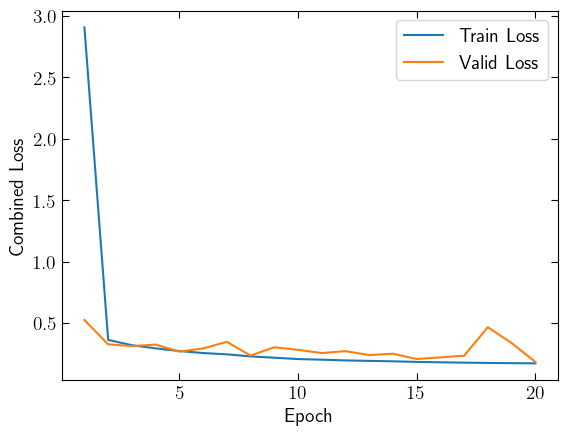

In [13]:
# plotting the loss
plt.plot(range(1,num_epochs+1),ntlosses,label='Train Loss')
plt.plot(range(1,num_epochs+1),nvlosses,label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Combined Loss')
plt.legend(fancybox=True)
plt.savefig('/arc/home/aydanmckay/mae_prods/plots/lossplot_'+datashort+'_'+scale+'_bl_'+str(batchlen)+'_lr'+str(lr)+'_ep'+str(num_epochs)+'.png')

In [14]:
# saving the algorithm
torch.save(model.state_dict(), '/arc/home/aydanmckay/mae_prods/models/'+datashort+'_'+scale+'_bl_'+str(batchlen)+'_lr'+str(lr)+'_ep'+str(num_epochs)+'.pth')

In [15]:
# loading the algorithm
model.load_state_dict(torch.load('/arc/home/aydanmckay/mae_prods/models/'+datashort+'_'+scale+'_bl_'+str(batchlen)+'_lr'+str(lr)+'_ep'+str(num_epochs)+'.pth'))
# model.eval()

<All keys matched successfully>

In [16]:
test_data = data_set(datafname,train=False,test=True)
test_dataloader = DataLoader(
    test_data,
    batch_size=batchlen,
    shuffle=False,
    num_workers=0
)
nosc_data = data_set(datafname,train=False,noscale=True)
nosc_dataloader = DataLoader(
    nosc_data,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

In [17]:
with torch.no_grad():
    pred_theta = []
    for thetas, xps, xp_es, ms, exts, dists in test_dataloader:
        xps = xps.to(device)
        ms = ms.to(device)
        thetas = thetas.to(device)
        
        dists = dists.to(device)
        xps = normalize(xps.T, dists).T
        
        output_xp, output_mag, preds = model(xps, ms)
        
        for pred in preds:
            pred_theta.append(pred)
    pred_theta = np.array([pred.to('cpu').numpy() for pred in pred_theta]).T
    us_pred_theta = np.array([pred_theta[0],pred_theta[1],tefscaler.inverse_transform(pred_theta[2].reshape(-1, 1)).flatten()])
    
    real_theta = []
    for thetas, xps, xp_es, ms, exts, dusts in nosc_dataloader:
        thetas = thetas.to(device)
        real_theta.append(thetas[0])
    real_theta = np.array([thet.to('cpu').numpy() for thet in real_theta]).T

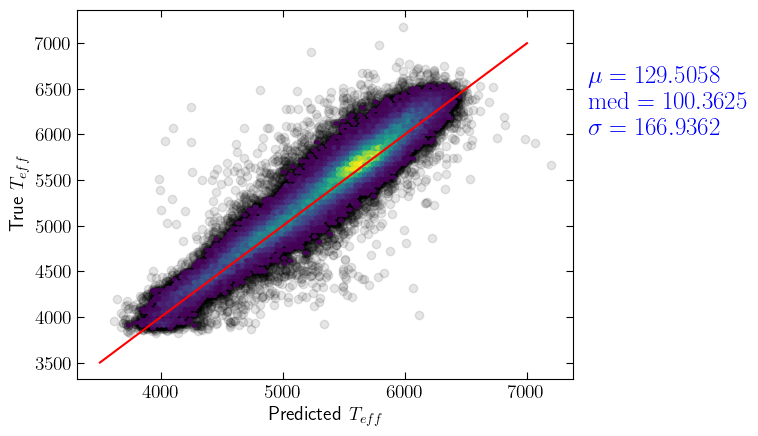

In [18]:
plt.figure()
plt.scatter(us_pred_theta[2],real_theta[2],c='k',alpha=.1)
plt.hexbin(us_pred_theta[2],real_theta[2],mincnt=5)
plt.plot([3500,7000],[3500,7000],'r')
plt.xlabel(r'Predicted $T_{eff}$')
plt.ylabel(r'True $T_{eff}$');

mu = np.mean(abs(real_theta[2]-us_pred_theta[2]))
median = np.median(abs(real_theta[2]-us_pred_theta[2]))
sigma = np.std(real_theta[2]-us_pred_theta[2])
textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
plt.text(7500,6000,textstr, color='b',fontsize=18);
plt.savefig('/arc/home/aydanmckay/mae_prods/plots/testaccuracyteff_'+datashort+'_'+scale+'_bl_'+str(batchlen)+'_lr'+str(lr)+'_ep'+str(num_epochs)+'.png')

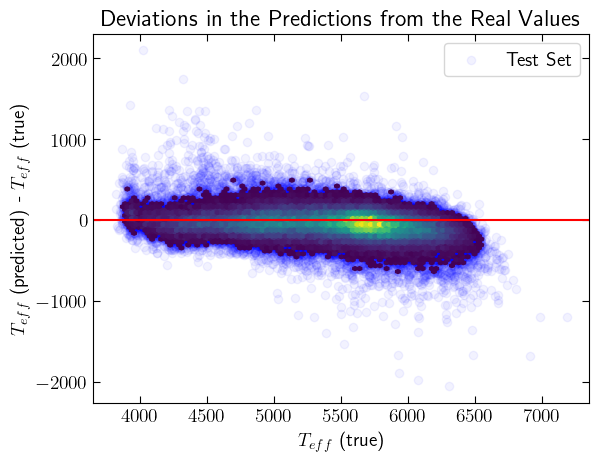

In [19]:
plt.scatter(real_theta[2],us_pred_theta[2]-real_theta[2],label='Test Set',color='b',alpha=.05)
plt.hexbin(real_theta[2],us_pred_theta[2]-real_theta[2],mincnt=5) # replace with train set when done
plt.axhline(c='r')
plt.xlabel(r'$T_{eff}$ (true)')
plt.ylabel(r'$T_{eff}$ (predicted) - $T_{eff}$ (true)')
plt.title('Deviations in the Predictions from the Real Values')
plt.legend();

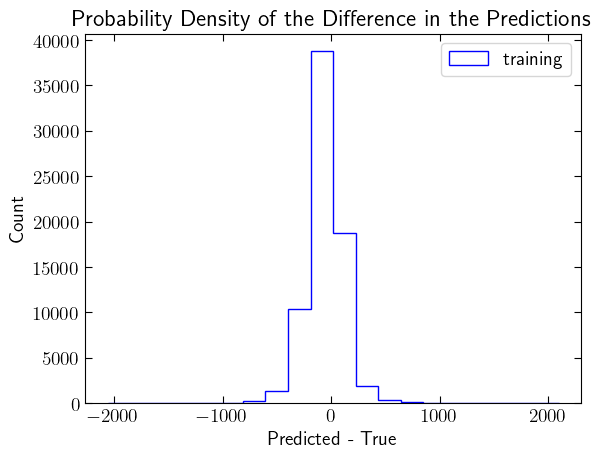

In [20]:
plt.hist(us_pred_theta[2]-real_theta[2],20,color='b',histtype='step',label='training')
plt.xlabel('Predicted - True')
plt.ylabel('Count')
plt.title('Probability Density of the Difference in the Predictions')
plt.legend();

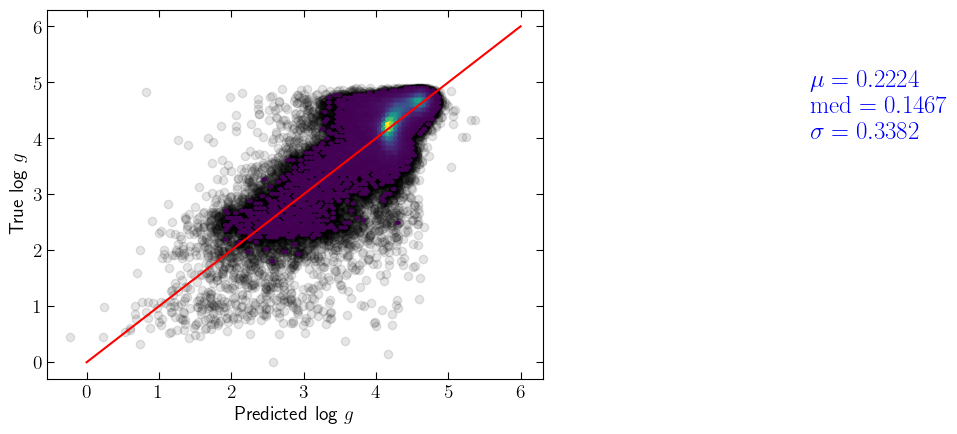

In [21]:
plt.scatter(us_pred_theta[1],real_theta[1],c='k',alpha=.1)
plt.hexbin(us_pred_theta[1],real_theta[1],mincnt=5)
plt.plot([0,6],[0,6],'r')
plt.xlabel(r'Predicted log $g$')
plt.ylabel(r'True log $g$');

mu = np.mean(abs(real_theta[1]-us_pred_theta[1]))
median = np.median(abs(real_theta[1]-us_pred_theta[1]))
sigma = np.std(real_theta[1]-us_pred_theta[1])
textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
plt.text(10,4,textstr, color='b',fontsize=18);
plt.savefig('/arc/home/aydanmckay/mae_prods/plots/testaccuracylogg_'+datashort+'_'+scale+'_bl_'+str(batchlen)+'_lr'+str(lr)+'_ep'+str(num_epochs)+'.png')

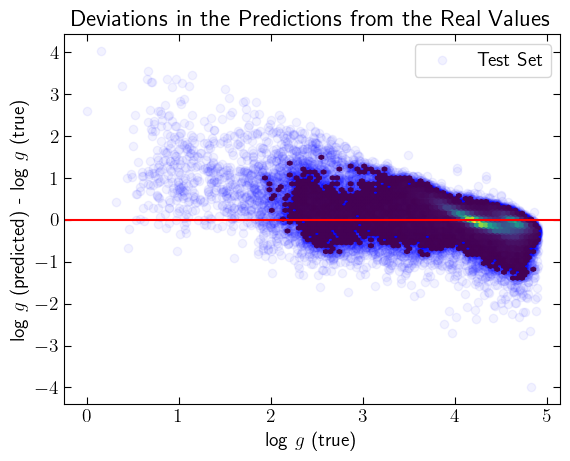

In [22]:
plt.scatter(real_theta[1],us_pred_theta[1]-real_theta[1],label='Test Set',color='b',alpha=.05)
plt.hexbin(real_theta[1],us_pred_theta[1]-real_theta[1],mincnt=5) # replace with train set when done
plt.axhline(c='r')
plt.xlabel(r'log $g$ (true)')
plt.ylabel(r'log $g$ (predicted) - log $g$ (true)')
plt.title('Deviations in the Predictions from the Real Values')
plt.legend();

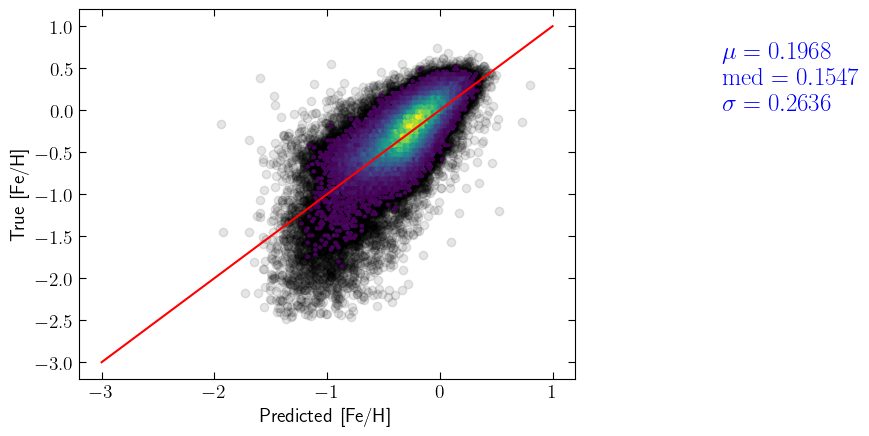

In [23]:
plt.scatter(us_pred_theta[0],real_theta[0],c='k',alpha=.1)
plt.hexbin(us_pred_theta[0],real_theta[0],mincnt=5)
plt.plot([-3,1],[-3,1],'r')
plt.xlabel(r'Predicted [Fe/H]')
plt.ylabel(r'True [Fe/H]');

mu = np.mean(abs(real_theta[0]-us_pred_theta[0]))
median = np.median(abs(real_theta[0]-us_pred_theta[0]))
sigma = np.std(real_theta[0]-us_pred_theta[0])
textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
plt.text(2.5,0,textstr, color='b',fontsize=18);
plt.savefig('/arc/home/aydanmckay/mae_prods/plots/testaccuracylogg_'+datashort+'_'+scale+'_bl_'+str(batchlen)+'_lr'+str(lr)+'_ep'+str(num_epochs)+'.png')

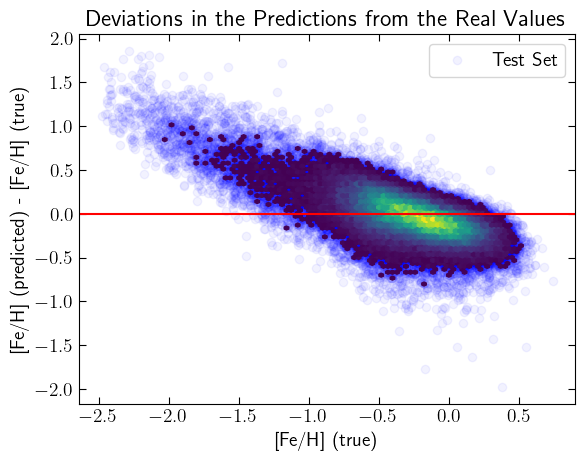

In [24]:
plt.scatter(real_theta[0],us_pred_theta[0]-real_theta[0],label='Test Set',color='b',alpha=.05)
plt.hexbin(real_theta[0],us_pred_theta[0]-real_theta[0],mincnt=5) # replace with train set when done
plt.axhline(c='r')
plt.xlabel(r'[Fe/H] (true)')
plt.ylabel(r'[Fe/H] (predicted) - [Fe/H] (true)')
plt.title('Deviations in the Predictions from the Real Values')
plt.legend();

In [25]:
# plt.scatter(us_pred_theta[0],real_theta[0],c=,alpha=.1)
# plt.hexbin(us_pred_theta[0],real_theta[0],mincnt=5)
# plt.plot([-5,1],[-5,1],'r')
# plt.xlabel(r'Predicted [Fe/H]')
# plt.ylabel(r'True [Fe/H]');